## Analysis MSMORDM

In [1]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
import time
import copy
import os
import functools
import random
import itertools
import pickle

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint,load_results)
from problem_formulation import get_model_for_problem_formulation
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import (perform_experiments,BaseEvaluator)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import preprocessing
from concurrent.futures import (ProcessPoolExecutor,ThreadPoolExecutor)
from scipy.spatial.distance import pdist, squareform

In [2]:
a_file = open("output_data/results_MSMORDM_dict.pkl", "rb")
results = pickle.load(a_file) #the results from the MSMORDM 


In [3]:
a_file = open("output_data/scenarios_MSMORDM_withpolicies.pkl", "rb")
scenarios_MSMORDM = pickle.load(a_file) #the reference scenarios as used in the MSMORDM


## Plots Epsilon progress

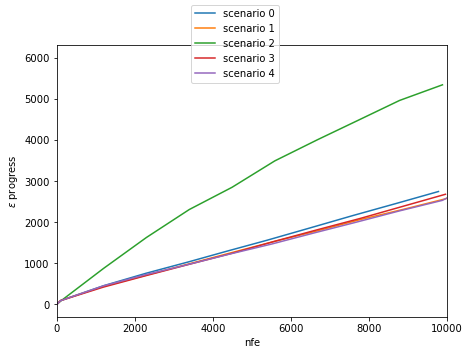

In [4]:
fig, (ax) = plt.subplots(ncols=1,figsize=(7,5))
for i, (_, convergence) in enumerate(results):
    ax.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax.set_ylabel('$\epsilon$ progress')
ax.set_xlabel('nfe')
plt.xlim([0,10000])
fig.legend(loc='upper center')
plt.savefig('EpsilonVolume_nfe1e4')
plt.show()


In [5]:
data_0 = results[0][0].iloc[:, 5::]
limits_0 = parcoords.get_limits(results[0][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])

data_1 = results[1][0].iloc[:, 5::]
limits_1 = parcoords.get_limits(results[1][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])

data_2 = results[2][0].iloc[:, 5::]
limits_2 = parcoords.get_limits(results[2][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])
                               
data_3 = results[3][0].iloc[:, 5::]
limits_3 = parcoords.get_limits(results[3][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])
                               
data_4 = results[4][0].iloc[:, 5::]
limits_4 = parcoords.get_limits(results[4][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])


In [9]:
data = results[0][0].iloc[:, 5::][['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
          'Expected Evacuation Costs']]
limits = parcoords.get_limits(data)

for i in ['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
          'Expected Evacuation Costs']:
    limits[i][1] = max([limits_4[i][1], limits_3[i][1], limits_2[i][1], 
                        limits_1[i][1], limits_0[i][1]])
    limits[i][0] = min([limits_4[i][0], limits_3[i][0], limits_2[i][0], 
                        limits_1[i][0], limits_0[i][0]])
    
limits #take a look at the generated limits 

,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,Expected Evacuation Costs
0,0.000000e+00,0.000000,0.000000
1,8.792176e+07,0.048806,171296.607787


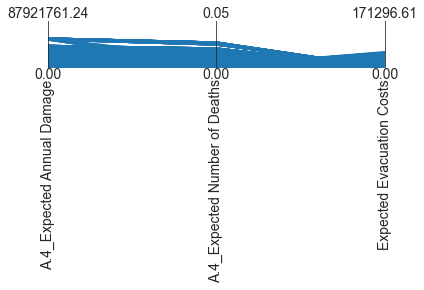

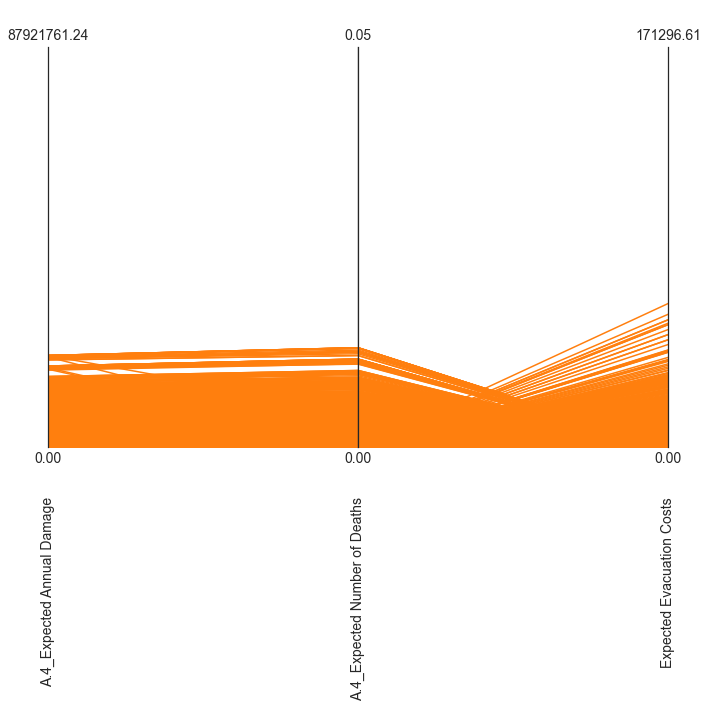

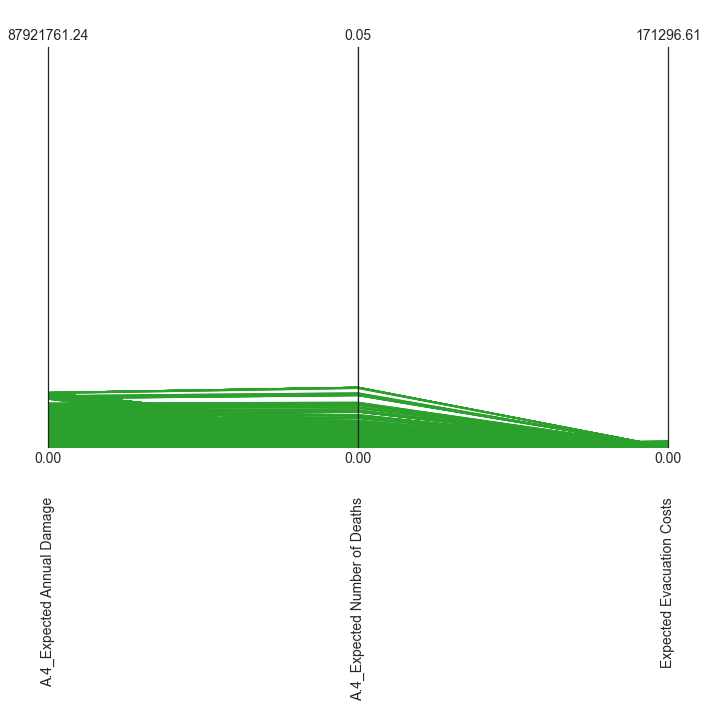

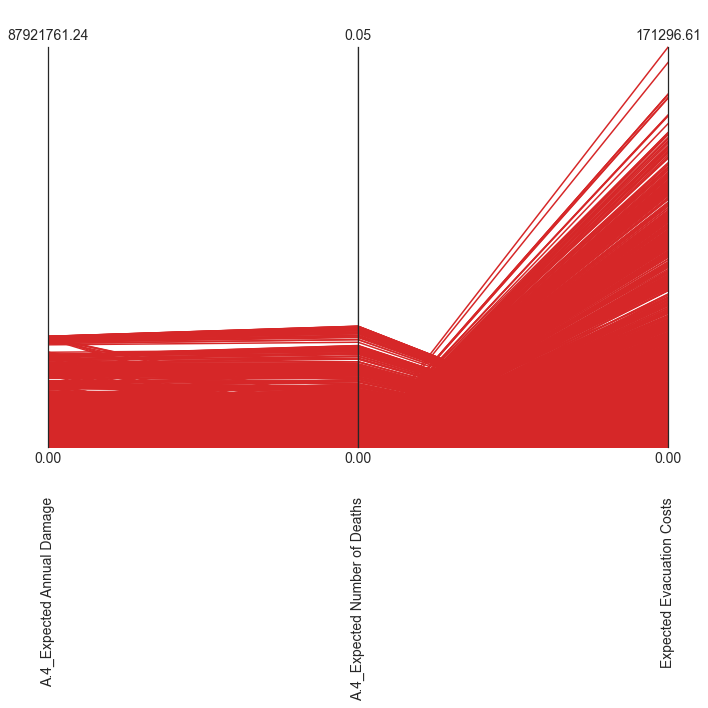

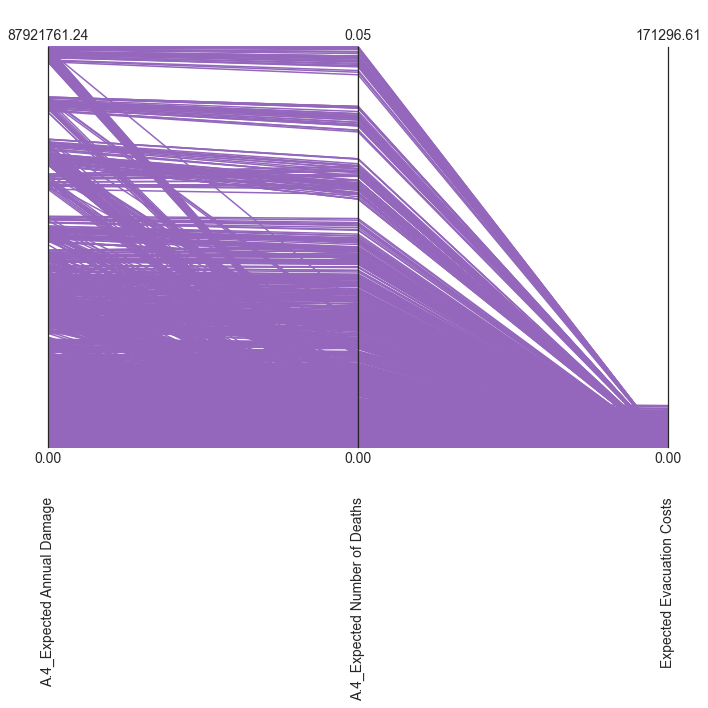

In [10]:
# plot the results 
colors = iter(sns.color_palette())
for i, (result, _) in enumerate(results):
    
    paraxes = parcoords.ParallelAxes(limits)
    color = next(colors)
    data = result.iloc[:, 5::]
    sns.set(rc = {'figure.figsize':(10,10)})
    paraxes.plot(data, label=f'scenario {i}', color=color)
        
    plt.savefig('Tradeoffs__noo100_nfe1e4_eps_0,1_scenario' + str(i))
    plt.show()

In [11]:
df_results = pd.DataFrame(results) 

## Deep Uncertainty 
Reevaluate under deep uncertainty 

In [12]:
#specify the policies 

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)
        

In [15]:
#randomly select 50 policies 
set_seed = 1234567 
random.seed(set_seed)
sampled_policies = random.sample(policies, 50)

In [ ]:
a_file = open("output_data/sampled_policies_deepuncertainty.pkl", "wb")
pickle.dump(sampled_policies, a_file)
a_file.close()

In [16]:
a_file = open("sampled_policies_deepuncertainty.pkl", "rb")
sampled_policies = pickle.load(a_file) #the reference scenarios as used in the MSMORDM



In [61]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 

with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(100, policies=sampled_policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 50 policies * 1 model(s) = 5000 experiments
100%|██████████████████████████████████████| 5000/5000 [26:45<00:00,  3.11it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [204]:
a_file = open("output_data/reeevaluation_results.pkl", "wb")
pickle.dump(reeevaluation_results, a_file)
a_file.close()

In [17]:
a_file = open("output_data/reeevaluation_results.pkl", "rb")
reeevaluation_results = pickle.load(a_file) 

Calculate the domain criterion.


In [18]:
experiments_deep, outcomes_deep = reeevaluation_results

thresholds = {'A.4_Expected Number of Deaths':0.005, 
              'A.4_Expected Annual Damage':200000,
             'Expected Evacuation Costs':50000}

overall_scores = {}
for policy in experiments_deep.policy.unique():
    logical = experiments_deep.policy == policy
    scores = {}
    for k, v in outcomes_deep.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/100 #divide by number of scenarios 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

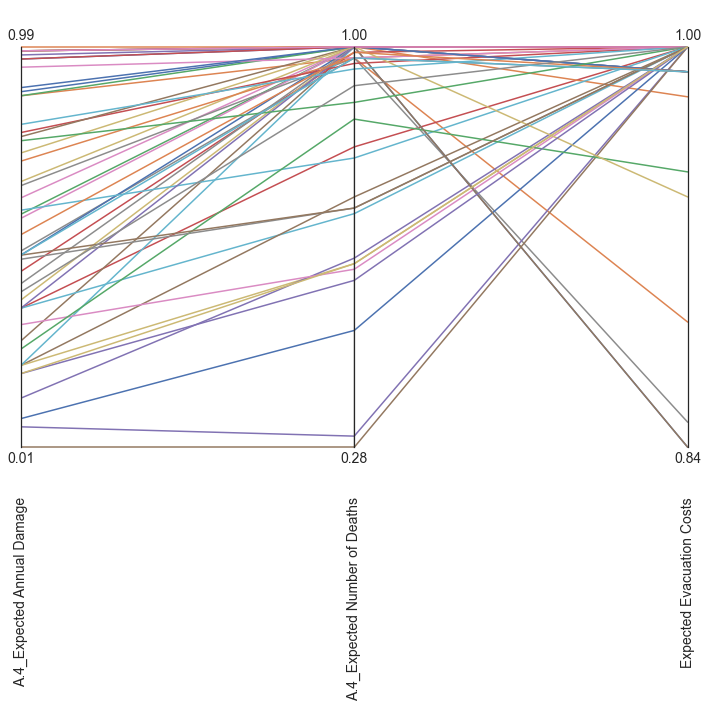

In [19]:
limits_deepuncertainty = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits_deepuncertainty)
paraxes.plot(overall_scores)
plt.savefig('DomainCriteria')
plt.show()

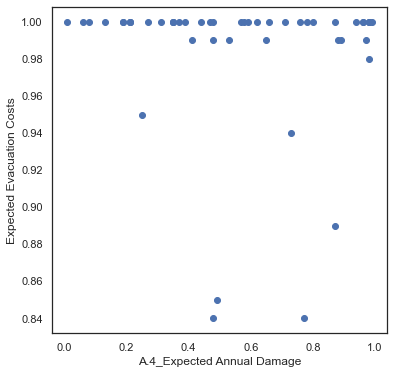

In [20]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(overall_scores['A.4_Expected Annual Damage'], 
                overall_scores['Expected Evacuation Costs'])

ax.set_xlabel('A.4_Expected Annual Damage')
ax.set_ylabel('Expected Evacuation Costs')
plt.savefig('figures/scatterplot_costs_damages')
plt.show()

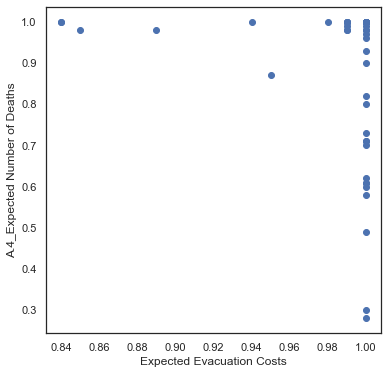

In [21]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(overall_scores['Expected Evacuation Costs'], 
                overall_scores['A.4_Expected Number of Deaths'])

ax.set_xlabel('Expected Evacuation Costs')
ax.set_ylabel('A.4_Expected Number of Deaths')
plt.savefig('figures/scatterplot_costs_deaths')
plt.show()

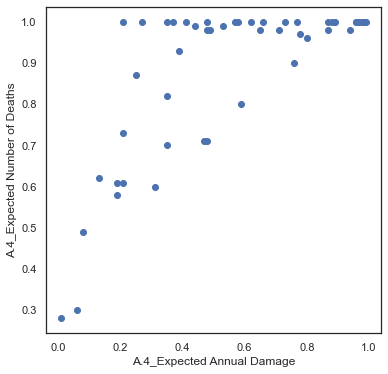

In [22]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(overall_scores['A.4_Expected Annual Damage'], 
                overall_scores['A.4_Expected Number of Deaths'])

ax.set_xlabel('A.4_Expected Annual Damage')
ax.set_ylabel('A.4_Expected Number of Deaths')
plt.savefig('figures/scatterplot_deaths_damages')
plt.show()